## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from functions import *
from fair_func import *
from fair_metrics import *

import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
data = pd.read_csv('updated_dataset1.csv')

In [3]:
data.head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,Days in jail,c_days_from_compas,is_recid,...,event,two_year_recid,High,Low,Language_Spanish,sex_Male,race_White,c_charge_degree_M,age_cat_young,age_cat_old
0,31,0,1,0,0,0,0,5,0,0,...,0,0,0,1,0,1,1,1,1,0
1,21,0,8,1,0,1,0,1,0,1,...,1,0,1,0,0,1,0,1,1,0
2,21,0,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,30,0,2,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,32,1,10,1,0,20,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


#### Select favourable and unfavourable outcome

In [4]:
target='two_year_recid'

fav=0
unfav=int(not fav)

#### Identify the protected groups and the respective advantageous and disadvantageous subsets

In [5]:
Male='sex_Male' 
Young='age_cat_young'
Race='race_White' 
Old='age_cat_old'

In [6]:
protected_groups=['Male','Young','Race','Old']

In [7]:
adv_groups = [{Male :0},{Race :1},{Young:1},{Old:1} ]
disadv_groups = [{Male :1},{Race :0},{Young:0},{Old:0} ]

### Applying Statistical Parity an disparate impact

In [8]:
SP=[]
DI=[]
Protected=[]
for groupe in range(0, len(protected_groups)):
    protected_group = list(adv_groups[groupe].keys())[0]
    adv_protected_group_value = adv_groups[groupe][protected_group]
    disadv_protected_group_value = disadv_groups[groupe][protected_group]
    statistical_parity, disparate_impact = statistical_parity_test(data, protected_group, adv_protected_group_value, disadv_protected_group_value, target, fav)
    
    SP.append(statistical_parity)
    DI.append(disparate_impact)
    Protected.append(protected_group)

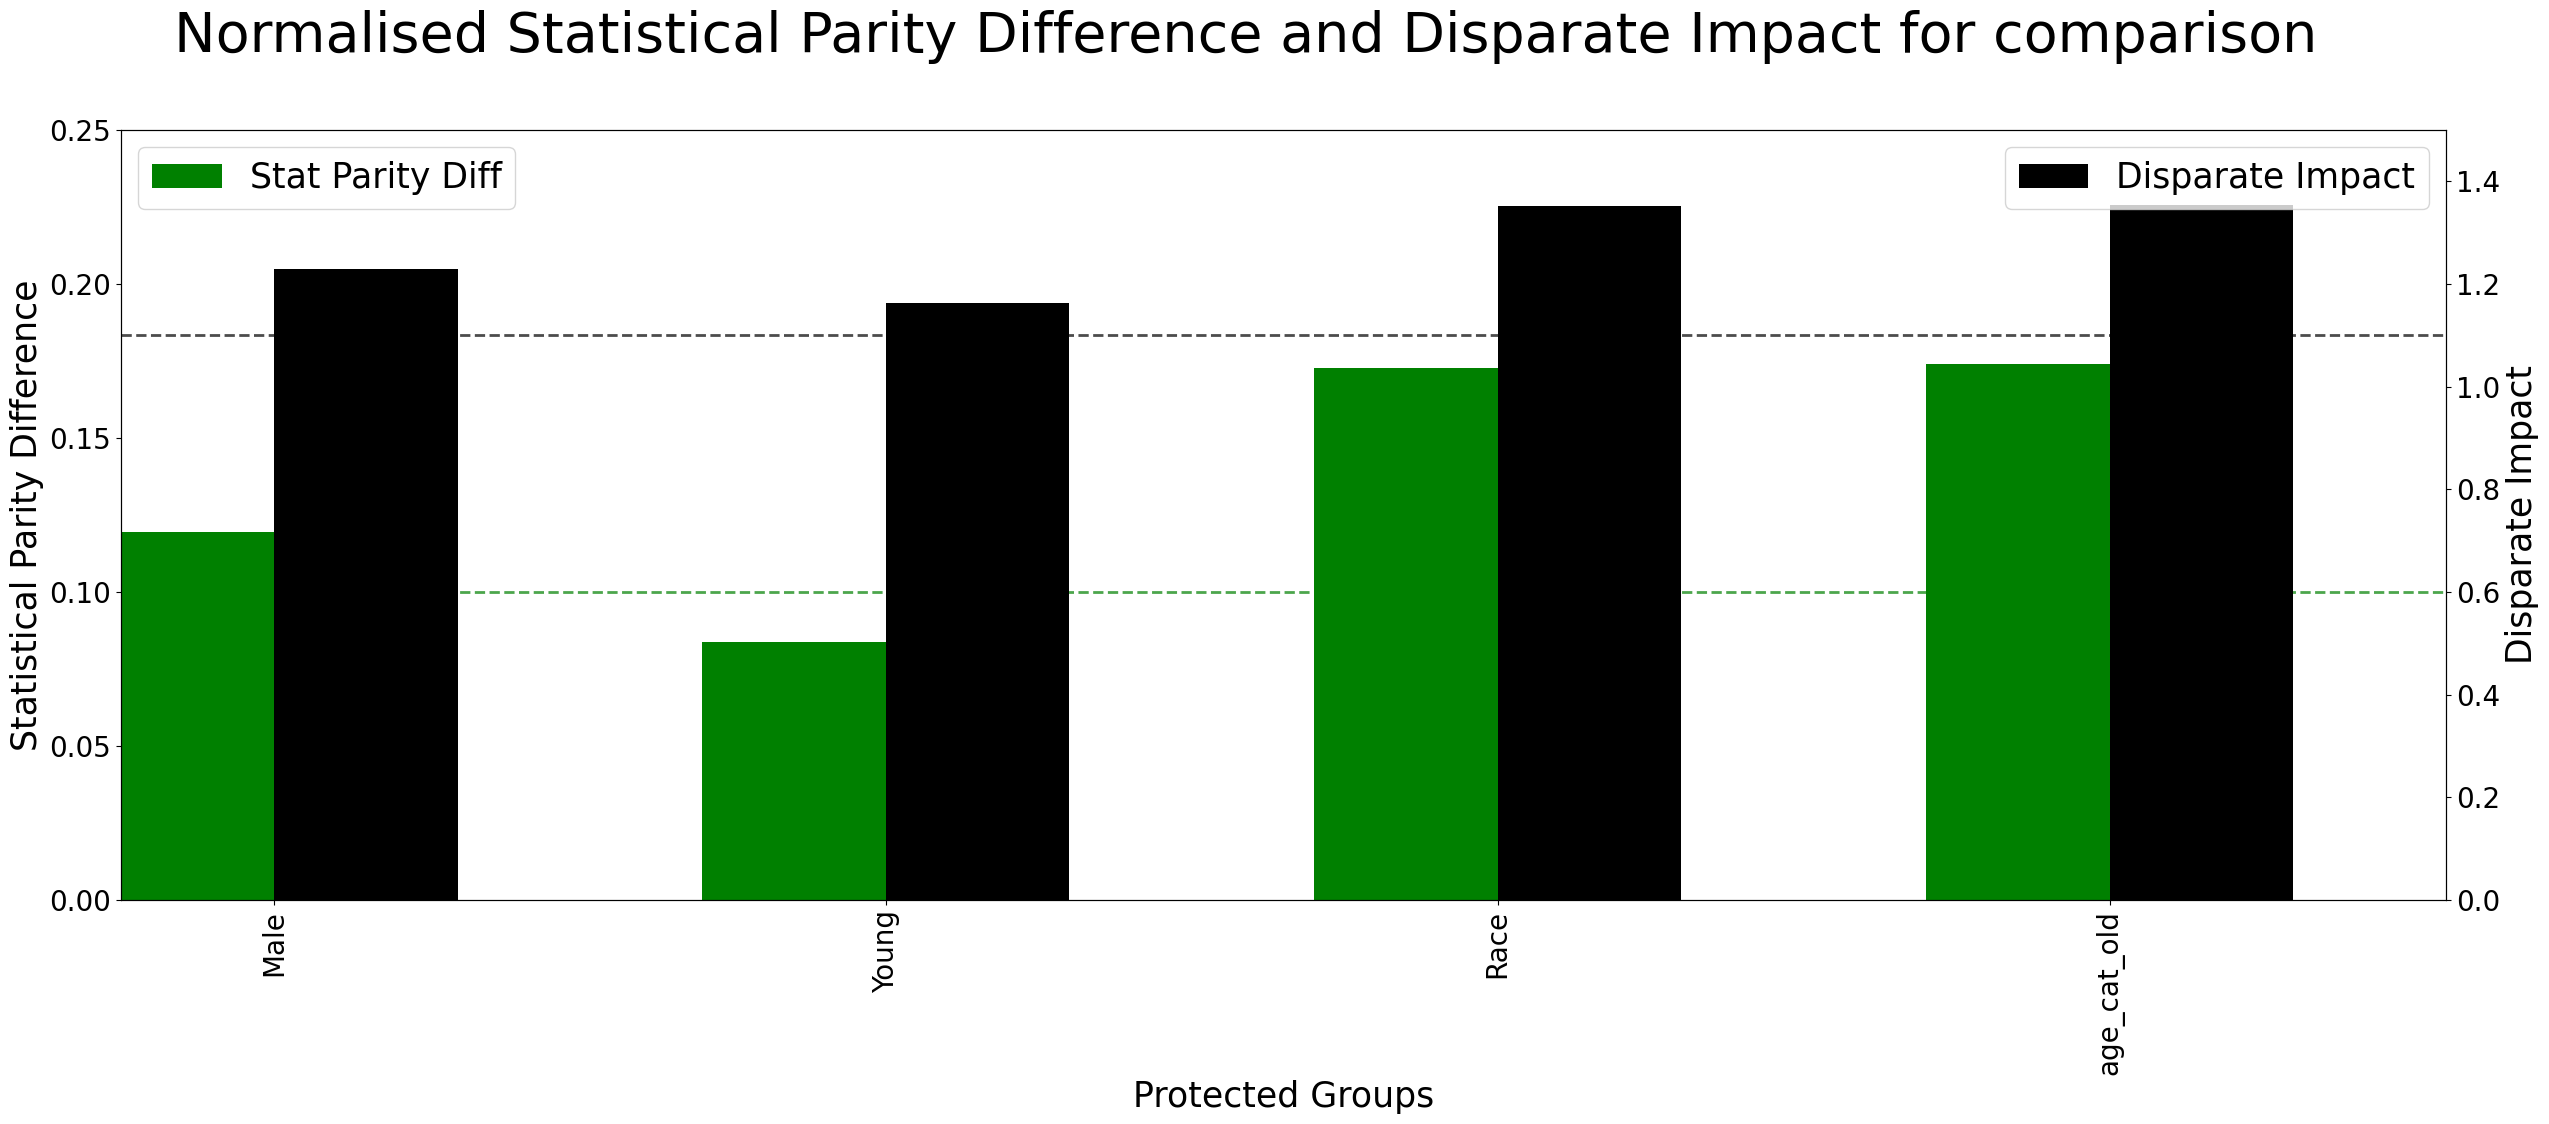

In [9]:
d = pd.DataFrame({'Protected_feature':Protected,'Statistical_Parity':SP,'Disparate_Impact':DI})
d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)

fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

fig.suptitle('Normalised Statistical Parity Difference and Disparate Impact for comparison', fontsize=40, y=1)

width = 0.3
ax.set_ylim(0, 0.25) 
ax2.set_ylim(0, 1.5) 

d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
       position=1, color='green', legend=False, figsize=(30,10), fontsize=20)
d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
       position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

ax.axhline(y=0.1, linestyle='dashed', linewidth=2, alpha=0.7, color='green')
ax2.axhline(y=1.10, linestyle='dashed', linewidth=2, alpha=0.7, color='black')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Male'
labels[1] = 'Young'
labels[2] = 'Race'


ax.set_xticklabels(labels)
ax.set_xlabel('Protected Groups', fontsize=25)
ax.set_ylabel('Statistical Parity Difference', fontsize=25)
ax2.set_ylabel('Disparate Impact', fontsize=25)

plt.show()

#### Fill in missing values

In [10]:
data.isna().sum()

age                        0
juv_fel_count              0
decile_score               0
juv_misd_count             0
juv_other_count            0
priors_count               0
days_b_screening_arrest    0
Days in jail               0
c_days_from_compas         0
is_recid                   0
r_days_from_arrest         0
violent_recid              0
is_violent_recid           0
decile_score.1             0
v_decile_score             0
priors_count.1             0
start                      0
end                        0
event                      0
two_year_recid             0
High                       0
Low                        0
Language_Spanish           0
sex_Male                   0
race_White                 0
c_charge_degree_M          0
age_cat_young              0
age_cat_old                0
dtype: int64

In [11]:
dataacf = data[['decile_score','two_year_recid','juv_misd_count','juv_other_count','priors_count','days_b_screening_arrest','Days in jail','c_days_from_compas','r_days_from_arrest','violent_recid','is_violent_recid','decile_score.1','v_decile_score','priors_count.1','start','end',Male,Young,Race,Old]]

In [12]:
biased_protected_groups = [Male, Young, Race, Old]

In [13]:
choice = Male

## Baseline model : Logistic Regression

In [14]:
y=dataacf['two_year_recid']
x=dataacf.drop(columns=['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [15]:
log_reg = LogisticRegression(random_state=0, solver='liblinear',
                              ).fit(X_train, y_train)

In [16]:
y_pred=log_reg.predict(X_test)
y_pred_prob=log_reg.predict_proba(X_test)[:,0]
print("Accuracy of the baseline model:", log_reg.score(X_test, y_test))

Accuracy of the baseline model: 0.8809201623815968


In [17]:
X_test

,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,Days in jail,c_days_from_compas,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,sex_Male,age_cat_young,race_White,age_cat_old
5546,1,0,0,2,-1,8,0,0,0,0,1,1,2,7,788,1,0,1,1
5955,1,0,0,0,-1,1,1,0,0,0,1,2,0,0,761,1,1,0,0
177,2,0,0,0,-1,1,1,0,0,0,2,3,0,0,1177,1,1,0,0
429,3,0,0,0,-1,1,1,0,0,0,3,4,0,0,945,1,1,0,0
2889,1,0,0,2,-5,3,5,0,0,0,1,1,2,0,1005,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2,0,0,0,0,0,0,0,0,0,2,2,0,0,1132,1,1,0,0
6090,3,0,0,0,-1,1,1,0,0,0,3,4,0,0,750,1,1,0,0
6615,10,0,0,3,0,13,0,0,0,1,10,8,3,13,50,1,1,0,0
4431,7,0,0,0,-1,2,1,0,0,0,7,5,0,1,879,0,1,1,0


In [18]:
A_full=log_reg.score(X_test[X_test[choice]==0], y_test[X_test[choice]==0]) 
B_full=log_reg.score(X_test[X_test[choice]==1], y_test[X_test[choice]==1]) 
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 3.633254713455958 %


## Additive counterfactual fair model by hand


In [19]:
y=dataacf['two_year_recid']
x=dataacf.drop(columns=['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [20]:
sens=X_train[biased_protected_groups]

#### Regressing each independant variable with sensitive variable

In [21]:
acf_decilescore = LinearRegression().fit(sens, X_train['decile_score'])
acf_juvmissedcount = LinearRegression().fit(sens, X_train['juv_misd_count'])
acf_juvothercount = LinearRegression().fit(sens, X_train['juv_other_count'])
acf_priorscount = LinearRegression().fit(sens, X_train['priors_count'])
acf_daysbscreeningarrest = LinearRegression().fit(sens, X_train['days_b_screening_arrest'])
acf_daysinjail = LinearRegression().fit(sens, X_train['Days in jail'])
acf_cdaysfromcompas = LinearRegression().fit(sens, X_train['c_days_from_compas'])
acf_rdaysfromarrest = LinearRegression().fit(sens, X_train['r_days_from_arrest'])
acf_violentrecid = LinearRegression().fit(sens, X_train['violent_recid'])
acf_isviolentrecid = LinearRegression().fit(sens, X_train['is_violent_recid'])
acf_decilescore1 = LinearRegression().fit(sens, X_train['decile_score.1'])
acf_vdecilescore1 = LinearRegression().fit(sens, X_train['v_decile_score'])
acf_priorscount1 = LinearRegression().fit(sens, X_train['priors_count.1'])
acf_start = LinearRegression().fit(sens, X_train['start'])
acf_end = LinearRegression().fit(sens, X_train['end'])

#### Calculate the residuals for each model

In [22]:
decilescore = X_train['decile_score'] - acf_decilescore.predict(sens)
juvmissedcount = X_train['juv_misd_count'] - acf_juvmissedcount.predict(sens)
juvothercount = X_train['juv_other_count'] - acf_juvothercount.predict(sens)
priorscount = X_train['priors_count'] - acf_priorscount.predict(sens)
daysbscreeningarrest = X_train['days_b_screening_arrest'] - acf_daysbscreeningarrest.predict(sens)
daysinjail = X_train['Days in jail'] - acf_daysinjail.predict(sens)
cdaysfromcompas = X_train['c_days_from_compas'] - acf_cdaysfromcompas.predict(sens)
rdaysfromarrest = X_train['r_days_from_arrest'] - acf_rdaysfromarrest.predict(sens)
violentrecid = X_train['violent_recid'] - acf_violentrecid.predict(sens)
isviolentrecid  = X_train['is_violent_recid'] - acf_isviolentrecid .predict(sens)
decilescore1 = X_train['decile_score.1'] - acf_decilescore1.predict(sens)
vdecilescore1  = X_train['v_decile_score'] - acf_vdecilescore1.predict(sens)
priorscount1 = X_train['priors_count.1'] - acf_priorscount1.predict(sens)
start = X_train['start'] - acf_start.predict(sens)
end = X_train['end'] - acf_end.predict(sens)

In [23]:
df_R=pd.DataFrame({'decilescore':decilescore, 'juvmissedcount':juvmissedcount, 'juvothercount':juvothercount, 
                   'priorscount':priorscount,
                'daysbscreeningarrest':daysbscreeningarrest, 'daysinjail':daysinjail, 'cdaysfromcompas':cdaysfromcompas,
                   'rdaysfromarrest':rdaysfromarrest,'violentrecid':violentrecid,'isviolentrecid':isviolentrecid,'decilescore1':decilescore1,'vdecilescore1':vdecilescore1,'priorscount1':priorscount1,'start':start,'end':end})

In [24]:
df_R

,decilescore,juvmissedcount,juvothercount,priorscount,daysbscreeningarrest,daysinjail,cdaysfromcompas,rdaysfromarrest,violentrecid,isviolentrecid,decilescore1,vdecilescore1,priorscount1,start,end
3827,-2.632921,-0.110431,-0.174517,-1.436961,-6.357631,-12.290457,-9.185537,-8.016021,-0.174517,-0.130554,-2.632921,-1.110646,-1.436961,-9.886835,401.748347
2945,-1.607658,-0.038643,-0.024787,-3.197294,-18.439126,-19.398837,-92.928067,-5.976203,-0.024787,-0.086301,-1.607658,-1.437457,-3.197294,-15.061805,375.082123
3254,2.531552,-0.157694,-0.170072,-2.945468,-6.027773,-2.937385,-57.999770,-7.094095,-0.170072,-0.145718,2.531552,3.181171,-2.945468,2.141852,-407.252868
3269,-1.772130,0.008620,-0.029232,-3.688787,3.231016,-17.751909,-66.113834,-6.898129,-0.029232,-0.071137,-1.772130,-0.729274,-3.688787,-11.090492,313.083338
611,-1.111576,-0.091959,-0.091568,-2.491320,-5.544549,-11.294016,-53.581960,-4.269398,-0.091568,-0.102917,-1.111576,0.911607,-2.491320,-5.893008,586.654174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,-2.607658,-0.038643,-0.024787,-5.197294,-4.439126,-21.398837,-106.928067,-5.976203,-0.024787,-0.086301,-2.607658,-1.437457,-5.197294,-15.061805,461.082123
4761,-4.111576,-0.091959,-0.091568,-0.491320,-4.544549,-12.294016,-54.581960,-4.269398,-0.091568,-0.102917,-4.111576,-3.088393,-0.491320,-5.893008,-274.345826
2143,-0.772130,0.008620,-0.029232,1.311213,2.231016,-14.751909,-65.113834,-6.898129,-0.029232,-0.071137,-0.772130,-0.729274,1.311213,-9.090492,-424.916662
3857,-0.632921,-0.110431,1.825483,0.563039,1.642369,-14.290457,-16.185537,-8.016021,1.825483,-0.130554,-0.632921,-3.110646,0.563039,-8.886835,399.748347


#### Fitting residuals to the dependent (target) variable

In [25]:
fair = LogisticRegression(random_state=0, solver='liblinear',
                              ).fit(df_R, y_train)

#### Calculate residuals for the test data

In [26]:
sens=X_test[biased_protected_groups]

In [27]:
decilescore = X_test['decile_score'] - acf_decilescore.predict(sens)
juvmissedcount = X_test['juv_misd_count'] - acf_juvmissedcount.predict(sens)
juvothercount = X_test['juv_other_count'] - acf_juvothercount.predict(sens)
priorscount = X_test['priors_count'] - acf_priorscount.predict(sens)
daysbscreeningarrest = X_test['days_b_screening_arrest'] - acf_daysbscreeningarrest.predict(sens)
daysinjail = X_test['Days in jail'] - acf_daysinjail.predict(sens)
cdaysfromcompas = X_test['c_days_from_compas'] - acf_cdaysfromcompas.predict(sens)
rdaysfromarrest = X_test['r_days_from_arrest'] - acf_rdaysfromarrest.predict(sens)
violentrecid = X_test['violent_recid'] - acf_violentrecid.predict(sens)
isviolentrecid  = X_test['is_violent_recid'] - acf_isviolentrecid .predict(sens)
decilescore1 = X_test['decile_score.1'] - acf_decilescore1.predict(sens)
vdecilescore1  = X_test['v_decile_score'] - acf_vdecilescore1.predict(sens)
priorscount1 = X_test['priors_count.1'] - acf_priorscount1.predict(sens)
start = X_test['start'] - acf_start.predict(sens)
end = X_test['end'] - acf_end.predict(sens)

In [28]:
df_R_test=pd.DataFrame({'decilescore':decilescore, 'juvmissedcount':juvmissedcount, 'juvothercount':juvothercount, 
                   'priorscount':priorscount,
                'daysbscreeningarrest':daysbscreeningarrest, 'daysinjail':daysinjail, 'cdaysfromcompas':cdaysfromcompas,
                   'rdaysfromarrest':rdaysfromarrest,'violentrecid':violentrecid,'isviolentrecid':isviolentrecid,'decilescore1':decilescore1,'vdecilescore1':vdecilescore1,'priorscount1':priorscount1,'start':start,'end':end})

In [29]:
y_pred_fair = fair.predict(df_R_test)
y_pred_prob_fair = fair.predict_proba(df_R_test)

In [30]:
print("Accuracy of the fair model:", fair.score(df_R_test, y_test))

Accuracy of the fair model: 0.8721244925575101


In [31]:
A_full=fair.score(df_R_test[sens[choice]==0], y_test[sens[choice]==0]) 
B_full=fair.score(df_R_test[sens[choice]==1], y_test[sens[choice]==1]) 
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 4.275665802744822 %


In [32]:
def acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv):
    """
    Fairness performance metrics for a additive counterfactually fair model to compare advantageous and
    disadvantageous groups of a protected variable

    :param tn_disadv: disadvantaged group's true negative
    :param fp_disadv: disadvantaged group's false positive
    :param fn_disadv: disadvantaged group's false negative
    :param tp_disadv: disadvantaged group's true positive
    :param tn_adv: advantaged group's true negative
    :param fp_adv: advantaged group's false positive
    :param fn_adv: advantaged group's false negative
    :param tp_adv: advantaged group's true positive
    :return: Equal Opportunity, Predictive Equality, Equalised Odds, Precision/Predictive Parity, Demographic Parity,
        Avg Odds Diff, Treatment Equality

    Examples
    --------
    acf_metrics=acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
    """

    # Equal Opportunity - advantageous and disadvantageous groups have equal FNR
    FNR_adv = fn_adv / (fn_adv + tp_adv)
    FNR_disadv = fn_disadv / (fn_disadv + tp_disadv)
    EOpp_diff = abs(FNR_disadv - FNR_adv)

    # Predictive equality  - advantageous and disadvantageous groups have equal FPR
    FPR_adv = fp_adv / (fp_adv + tn_adv)
    FPR_disadv = fp_disadv / (fp_disadv + tn_disadv)
    pred_eq_diff = abs(FPR_disadv - FPR_adv)

    # Equalised Odds - advantageous and disadvantageous groups have equal TPR + FPR
    TPR_adv = tp_adv / (tp_adv + fn_adv)
    TPR_disadv = tp_disadv / (tp_disadv + fn_disadv)
    EOdds_diff = abs((TPR_disadv + FPR_disadv) - (TPR_adv + FPR_adv))

    # Predictive Parity - advantageous and disadvantageous groups have equal PPV/Precision (TP/TP+FP)
    prec_adv = (tp_adv)/(tp_adv + fp_adv)
    prec_disadv = (tp_disadv)/(tp_disadv + fp_disadv)
    prec_diff = abs(prec_disadv - prec_adv)

    # Demographic Parity - ratio of (instances with favourable prediction) / (total instances)
    demo_parity_adv = (tp_adv + fp_adv) / (tn_adv + fp_adv + fn_adv + tp_adv)
    demo_parity_disadv = (tp_disadv + fp_disadv) / \
        (tn_disadv + fp_disadv + fn_disadv + tp_disadv)
    demo_parity_diff = abs(demo_parity_disadv - demo_parity_adv)

    # Average of Difference in FPR and TPR for advantageous and disadvantageous groups
    AOD = 0.5*((FPR_disadv - FPR_adv) + (TPR_disadv - TPR_adv))

    # Treatment Equality  - advantageous and disadvantageous groups have equal ratio of FN/FP
    TE_adv = fn_adv/fp_adv
    TE_disadv = fn_disadv/fp_disadv
    TE_diff = abs(TE_disadv - TE_adv)

    return [('Equal Opps', EOpp_diff),
            ('PredEq', pred_eq_diff), ('Equal Odds',
                                       EOdds_diff), ('PredParity', prec_diff),
            ('DemoParity', demo_parity_diff), ('AOD', abs(AOD)), ('TEq', TE_diff)]

In [33]:
tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(y_test[sens[choice]==0], y_pred_fair[sens[choice]==0]).ravel()
tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(y_test[sens[choice]==1], y_pred_fair[sens[choice]==1]).ravel()

acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
acf_metrics

[('Equal Opps', 0.05412587412587412),
 ('PredEq', 0.04058521112328817),
 ('Equal Odds', 0.01354066300258605),
 ('PredParity', 0.014499518188388238),
 ('DemoParity', 0.0931451239234607),
 ('AOD', 0.006770331501293025),
 ('TEq', 0.40331807780320367)]

## Additive Counterfactual Model using the class

In [34]:
independent_vars = ['decile_score','juv_misd_count','juv_other_count','priors_count','days_b_screening_arrest','Days in jail','c_days_from_compas','r_days_from_arrest','violent_recid','is_violent_recid','decile_score.1','v_decile_score','priors_count.1','start','end']
biased_protected_groups = [Male,Young,Race,Old]

sens_train = X_train[biased_protected_groups]
sens_test = X_test[biased_protected_groups]

In [35]:
import ACF as acf_class

acf = acf_class.ACF(X_train, X_test, y_train, y_test, sens_train, sens_test, 
                    independent_vars)

main_model = LogisticRegression(random_state=0, 
                                solver='liblinear' 
                               )

acf_model = acf.fit(main_model)

In [36]:
y_pred_fair_class = acf.predict()

In [37]:
y_pred_prob_class = acf.predict_proba()

In [38]:
acf.score()

Accuracy of additive counterfactual fair model: 0.8721244925575101


0.8721244925575101

## Model Fairness Metrics

In [39]:
tn_disadv, fp_disadv, fn_disadv, tp_disadv = acf.confusion_mat(choice, 0)
tn_adv, fp_adv, fn_adv, tp_adv = acf.confusion_mat(choice, 1)

In [40]:
acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
acf_metrics

[('Equal Opps', 0.05412587412587412),
 ('PredEq', 0.04058521112328817),
 ('Equal Odds', 0.01354066300258605),
 ('PredParity', 0.014499518188388238),
 ('DemoParity', 0.0931451239234607),
 ('AOD', 0.006770331501293025),
 ('TEq', 0.40331807780320367)]

In [41]:
def fair_metrics(y_actual, y_pred_prob, y_pred_binary, X_test, protected_group_name,
                 adv_val, disadv_val):
    
    tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(
        y_actual[X_test[protected_group_name] == adv_val],
        y_pred_binary[X_test[protected_group_name] == adv_val]).ravel()

    tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(
        y_actual[X_test[protected_group_name] == disadv_val],
        y_pred_binary[X_test[protected_group_name] == disadv_val]).ravel()

    # Receiver operating characteristic
    roc_adv = roc_auc_score(y_actual[X_test[protected_group_name] == adv_val],
                            y_pred_prob[X_test[protected_group_name] == adv_val])
    roc_disadv = roc_auc_score(y_actual[X_test[protected_group_name] == disadv_val],
                               y_pred_prob[X_test[protected_group_name] == disadv_val])

    roc_diff = abs(roc_disadv - roc_adv)

    # Average precision score
    ps_adv = average_precision_score(
        y_actual[X_test[protected_group_name] == adv_val],
        y_pred_prob[X_test[protected_group_name] == adv_val])
    ps_disadv = average_precision_score(
        y_actual[X_test[protected_group_name] == disadv_val],
        y_pred_prob[X_test[protected_group_name] == disadv_val])

    ps_diff = abs(ps_disadv - ps_adv)

    # Equal Opportunity - advantageous and disadvantageous groups have equal FNR
    FNR_adv = fn_adv / (fn_adv + tp_adv)
    FNR_disadv = fn_disadv / (fn_disadv + tp_disadv)
    EOpp_diff = abs(FNR_disadv - FNR_adv)

    # Predictive equality  - advantageous and disadvantageous groups have equal FPR
    FPR_adv = fp_adv / (fp_adv + tn_adv)
    FPR_disadv = fp_disadv / (fp_disadv + tn_disadv)
    pred_eq_diff = abs(FPR_disadv - FPR_adv)

    # Equalised Odds - advantageous and disadvantageous groups have equal TPR + FPR
    TPR_adv = tp_adv / (tp_adv + fn_adv)
    TPR_disadv = tp_disadv / (tp_disadv + fn_disadv)
    EOdds_diff = abs((TPR_disadv + FPR_disadv) - (TPR_adv + FPR_adv))

    # Predictive Parity - advantageous and disadvantageous groups have equal PPV/Precision (TP/TP+FP)
    prec_adv = (tp_adv)/(tp_adv + fp_adv)
    prec_disadv = (tp_disadv)/(tp_disadv + fp_disadv)
    prec_diff = abs(prec_disadv - prec_adv)

    # Demographic Parity - ratio of (instances with favourable prediction) / (total instances)
    demo_parity_adv = (tp_adv + fp_adv) / (tn_adv + fp_adv + fn_adv + tp_adv)
    demo_parity_disadv = (tp_disadv + fp_disadv) / \
        (tn_disadv + fp_disadv + fn_disadv + tp_disadv)
    demo_parity_diff = abs(demo_parity_disadv - demo_parity_adv)

    # Average of Difference in FPR and TPR for advantageous and disadvantageous groups
    AOD = 0.5*((FPR_disadv - FPR_adv) + (TPR_disadv - TPR_adv))

    # Treatment Equality  - advantageous and disadvantageous groups have equal ratio of FN/FP
    TE_adv = fn_adv/fp_adv
    TE_disadv = fn_disadv/fp_disadv
    TE_diff = abs(TE_disadv - TE_adv)

    return [('AUC', roc_diff), ('Avg PrecScore', ps_diff), ('Equal Opps', EOpp_diff),
            ('PredEq', pred_eq_diff), ('Equal Odds',
                                       EOdds_diff), ('PredParity', prec_diff),
            ('DemoParity', demo_parity_diff), ('AOD', abs(AOD)), ('TEq', TE_diff)]

In [42]:
logistic_reg_fair_metrics = fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, 1, 0)
logistic_reg_fair_metrics

[('AUC', 0.021255310583583015),
 ('Avg PrecScore', 0.08596805605322713),
 ('Equal Opps', 0.016153846153846158),
 ('PredEq', 0.058137980807783804),
 ('Equal Odds', 0.04198413465393758),
 ('PredParity', 0.0006435487974617571),
 ('DemoParity', 0.12057837923478643),
 ('AOD', 0.02099206732696881),
 ('TEq', 0.10232843137254899)]

In [43]:
labels, log_reg_model = zip(*logistic_reg_fair_metrics)
headers, acf_model = zip(*acf_metrics)
ACF={'Metrics':headers[0:6], 
             'Baseline Model':list(log_reg_model[2:8]), 'ACF Fair Model':list(acf_model[0:6])}
ACF_table=pd.DataFrame.from_dict(ACF)
ACF_table

,Metrics,Baseline Model,ACF Fair Model
0,Equal Opps,0.016154,0.054126
1,PredEq,0.058138,0.040585
2,Equal Odds,0.041984,0.013541
3,PredParity,0.000644,0.014500
4,DemoParity,0.120578,0.093145
5,AOD,0.020992,0.006770


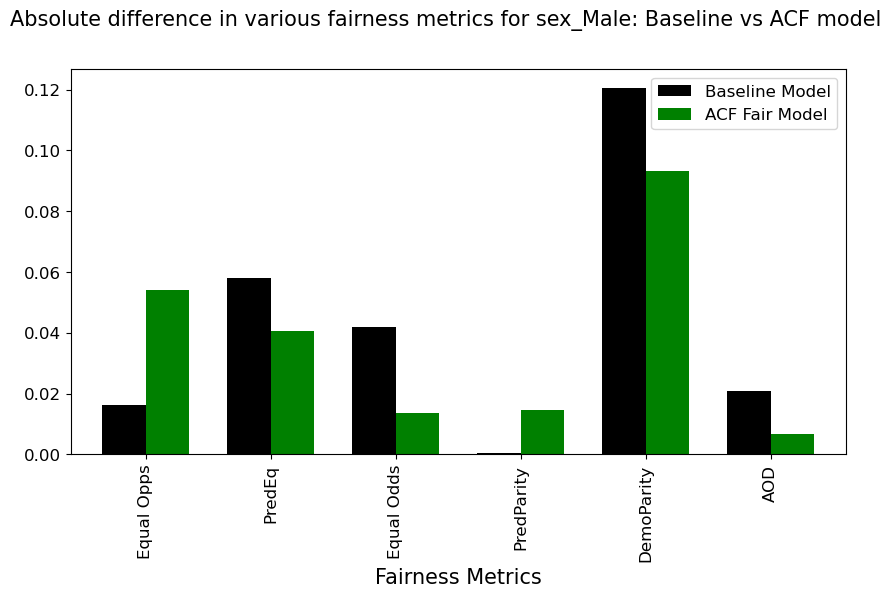

In [44]:
ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference in various fairness metrics for {}: Baseline vs ACF model'.format(choice),  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

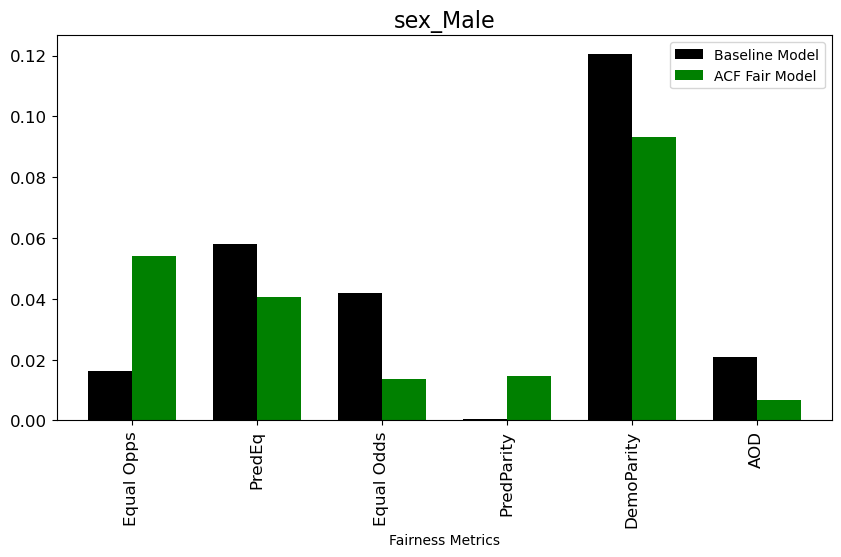

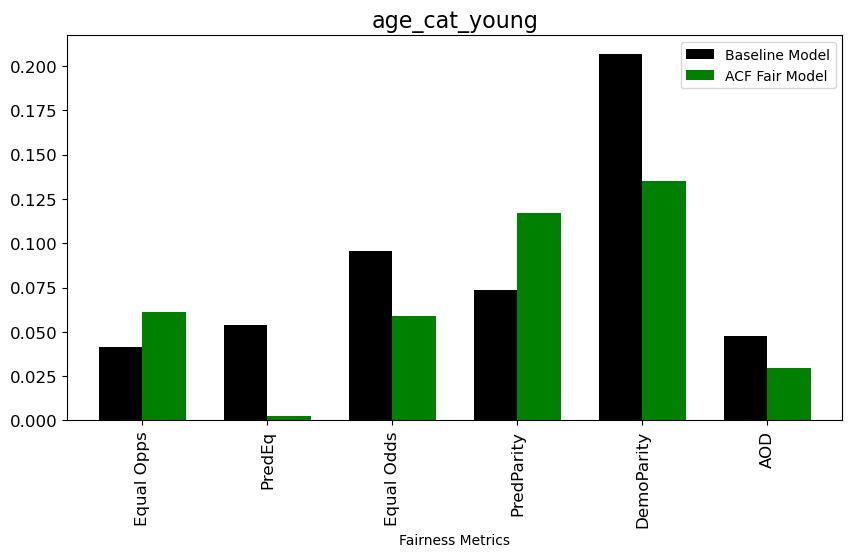

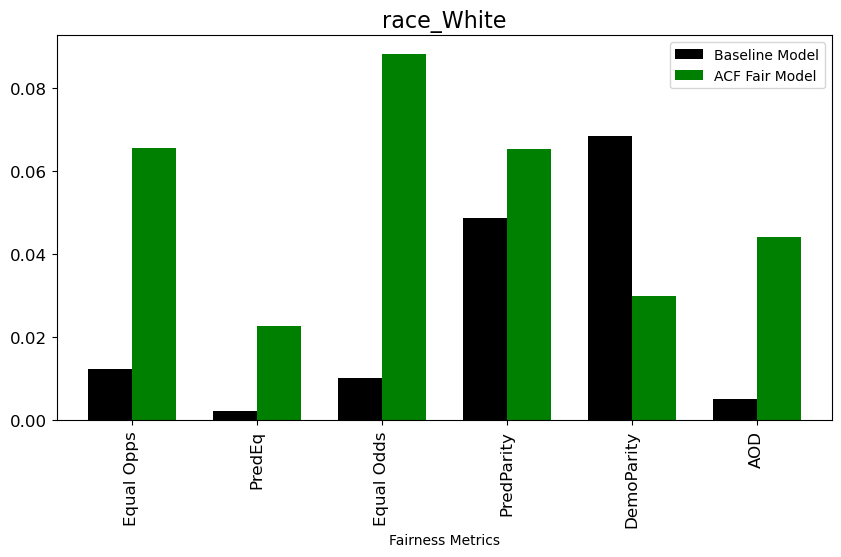

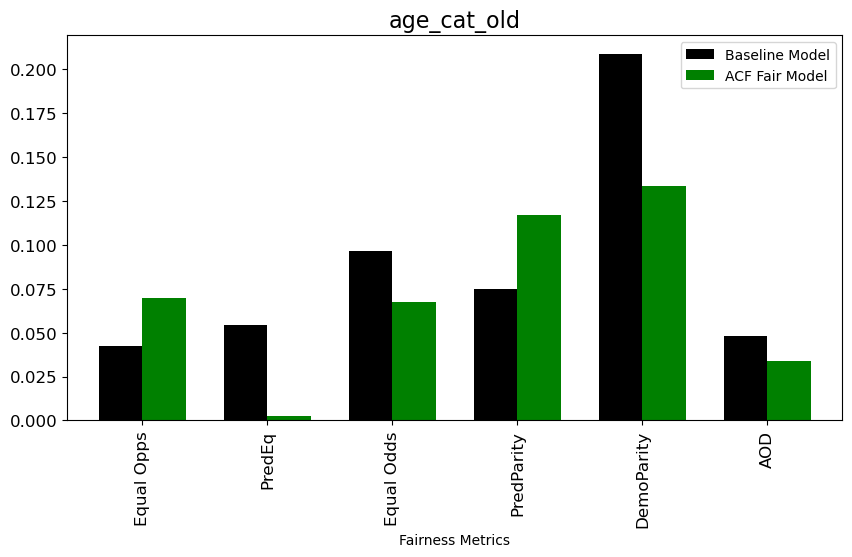

In [45]:
for groupe in range(0, len(biased_protected_groups)):
    choice = biased_protected_groups[groupe]
    protected_group = list(adv_groups[groupe].keys())[0]
    adv_protected_group_value = adv_groups[groupe][protected_group]
    disadv_protected_group_value = disadv_groups[groupe][protected_group]
    
    tn_disadv, fp_disadv, fn_disadv, tp_disadv = acf.confusion_mat(choice, disadv_protected_group_value)
    tn_adv, fp_adv, fn_adv, tp_adv = acf.confusion_mat(choice, adv_protected_group_value)
    
    acf_metrics = acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
    logistic_reg_fair_metrics = fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, adv_protected_group_value, disadv_protected_group_value)
    
    labels, log_reg_model = zip(*logistic_reg_fair_metrics)
    headers, acf_model = zip(*acf_metrics)
    ACF={'Fairness Metrics':headers[0:6], 
             'Baseline Model':list(log_reg_model[2:8]), 'ACF Fair Model':list(acf_model[0:6])}
    ACF_table=pd.DataFrame.from_dict(ACF) 
    
    ax = ACF_table.plot.bar(x='Fairness Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
    plt.title(choice, fontsize=16)
plt.show()

## Model performance metrics 

In [46]:
def accuracy_metrics(y_actual, y_pred_prob_ww, y_pred_prob_wow, y_pred_binary_ww,
                     y_pred_binary_wow, X_test):
   

    tn_ww, fp_ww, fn_ww, tp_ww = confusion_matrix(
        y_actual, y_pred_binary_ww).ravel()  # y_true, y_pred
    tn_wow, fp_wow, fn_wow, tp_wow = confusion_matrix(
        y_actual, y_pred_binary_wow).ravel()

    # Receiver operating characteristic
    auroc_ww = roc_auc_score(y_actual, y_pred_prob_ww)
    auroc_wow = roc_auc_score(y_actual, y_pred_prob_wow)

    # Gini = 2*AUROC - 1
    gini_ww = 2*auroc_ww - 1
    gini_wow = 2*auroc_wow - 1

    # Average precision score
    ps_ww = average_precision_score(y_actual, y_pred_binary_ww)
    ps_wow = average_precision_score(y_actual, y_pred_binary_wow)

    # Precision (TP/TP+FP)
    prec_ww = (tp_ww)/(tp_ww + fp_ww)
    prec_wow = (tp_wow)/(tp_wow + fp_wow)

    # Recall - True Positive Rate = TP/TP+FN
    recall_ww = tp_ww/(tp_ww + fn_ww)
    recall_wow = tp_wow/(tp_wow + fn_wow)

    # False Negative Rate = FN/(FN+TP)
    FNR_ww = fn_ww/(fn_ww + tp_ww)
    FNR_wow = fn_wow/(fn_wow + tp_wow)

    F1_ww = (2*prec_ww*recall_ww)/(prec_ww + recall_ww)
    F1_wow = (2*prec_wow*recall_wow)/(prec_wow + recall_wow)

    return auroc_ww, gini_ww, ps_ww, prec_ww, recall_ww, FNR_ww, F1_ww, auroc_wow, gini_wow, ps_wow,  prec_wow, recall_wow, FNR_wow, F1_wow,

In [47]:
model_perf=[accuracy_metrics(y_test, y_pred_prob, y_pred_prob_class, 
                          y_pred, y_pred_fair_class, X_test)]

headers=["AUC", "Gini", "Avg Precision Score", "Precision", "Sensitivity", "False Negative Rate", 
         "F1 Score"]

B = list(model_perf[0])[:len(list(model_perf[0]))//2]
C = list(model_perf[0])[len(list(model_perf[0]))//2:]


model_table={'Metrics':headers, 
             'Baseline':B, 'ACF':C}

model_table_df=pd.DataFrame.from_dict(model_table)
model_table_df

,Metrics,Baseline,ACF
0,AUC,0.050712,0.062402
1,Gini,-0.898577,-0.875196
2,Avg Precision Score,0.807038,0.797531
3,Precision,0.843490,0.842553
4,Sensitivity,0.906250,0.883929
5,False Negative Rate,0.093750,0.116071
6,F1 Score,0.873745,0.862745


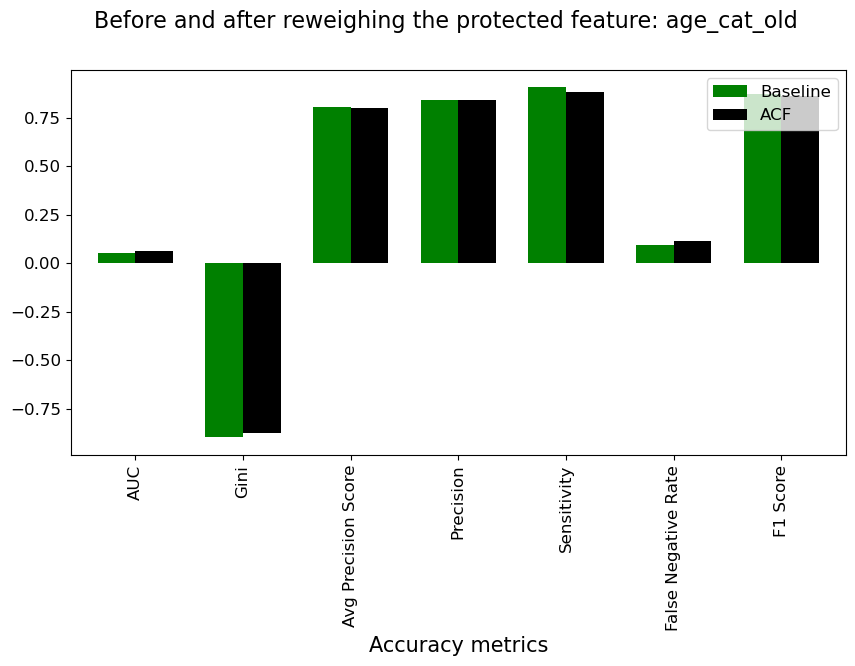

In [48]:
ax = model_table_df.iloc[:,:].plot.bar(x='Metrics', rot=90, width = 0.7, 
                                                       color=['green', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Before and after reweighing the protected feature: {}'.format(choice),  fontsize=16, y=1)



patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Accuracy metrics', fontsize=15)

plt.show()